In [1]:
!pip install transformers datasets torch spacy


In [2]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.9 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.2 MB/s eta 0:00:00


In [5]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f90e18e9eb2c435d45939c8bb456068fc5c5e41994262ab90bc1e1763eb3b73c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [6]:
pip install transformers datasets torch


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install transformers torch datasets


Note: you may need to restart the kernel to use updated packages.


DATA PREPROCESSING

In [9]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# List of medical stopwords (e.g., words that are essential in the medical field)
medical_stopwords = set([
    "hemoglobin", "RBC", "WBC", "platelet", "count", "level", "normal", "anemia", "blood", 
    "cells", "oxygen", "immune", "system", "function", "test", "range", "cells/µL", "g/dL", 
    "symptoms", "fatigue", "weakness", "indicates", "may", "suggests", "mild", "serious", "evaluation", "suggest", "levels"
])

# Additional stopwords to retain for context
additional_stopwords = set([
    "is", "are", "the", "in", "at", "of", "to", "a", "an", "and", "or", "on", "for", "with"
])

# Combine medical stopwords with general stopwords
stop_words = stopwords.words('english')
all_stopwords = set(stop_words) | medical_stopwords | additional_stopwords

# Function to preprocess medical reports
def preprocess_medical_text(text):
    # Remove newlines and extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation, but keep periods, commas, etc.
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stopwords, but keep medical stopwords and numbers
    tokens = [word for word in tokens if word.lower() not in all_stopwords]
    
    # Reconstruct the text after tokenization and removal
    processed_text = ' '.join(tokens)
    
    return processed_text

# Function to preprocess the dataset
def preprocess_dataset(df):
    # Drop the 'SNO.' column if present
    if 'SNO.' in df.columns:
        df = df.drop(columns=['SNO.'])
    
    # Remove spaces from column names
    df.columns = df.columns.str.replace(' ', '')
    
    # Preprocess the 'SUMMARY' column
    df['SUMMARY'] = df['SUMMARY'].apply(preprocess_medical_text)
    
    return df

# Sample dataset (replace with your actual dataset)
data = pd.read_excel("/kaggle/input/t5-project-updated/PROJECT_DATA.xlsx")

# Create DataFrame from the sample data
df = pd.DataFrame(data)

# Preprocess the dataset
processed_df = preprocess_dataset(df)

# Print the processed DataFrame
print(processed_df)

      MCV  MCHC    HB   RBC    WBC    PLT  RDWCV  NEUTRO  LYMPHO  \
0    87.7  30.1   7.3  2.77  10.00  189.0   11.4    50.1   43.20   
1    88.2  20.2   7.3  2.84  10.00  180.0   11.4    52.3   42.40   
2    77.0  29.5   9.0  3.97   7.20  148.0   13.7    60.7   30.70   
3    77.9  29.8   3.8  4.22   6.00  143.0   17.0    63.5   30.20   
4    80.6  29.7   0.4  3.93   4.20  236.0   15.1    53.7   39.10   
..    ...   ...   ...   ...    ...    ...    ...     ...     ...   
277  66.5  28.7  10.0  5.25   7.70  403.0   17.0    60.9   33.20   
278  92.4  32.5  14.9  4.97   4.76  264.0   12.5    49.4    1.87   
279  89.9  33.1  15.3  5.14   5.22  246.0   13.4    56.7    1.67   
280  80.6  30.0  12.0  4.96   8.12  433.0   14.2    61.1    2.53   
281  86.4  32.3  13.6  4.87  14.90  400.0   13.3    66.6    4.05   

                                               SUMMARY  
0    report shows 7.3 g/dL suggesting reduced oxyge...  
1    CBC report 7.3 g/dL indicate reduced oxygen-ca...  
2    CBC rep

In [10]:
# Check the most common words in the SUMMARY column
from collections import Counter

# Join all summaries into a single string for word frequency analysis
all_words = ' '.join(processed_df['SUMMARY']).split()
word_freq = Counter(all_words)
print(word_freq.most_common(10))  # Print the 10 most common words


[('cells/µL', 707), ('cell', 507), ('thousand', 430), ('red', 373), ('g/dL', 295), ('indicating', 263), ('RDW-CV', 238), ('low', 219), ('healthy', 177), ('million', 175)]


In [11]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd

# Assuming `processed_df` is already preprocessed and ready

# Format input text (lab values) and target text (summary) for T5
processed_df['input_text'] = processed_df.apply(
    lambda row: f"MCV: {row['MCV']} MCHC: {row['MCHC']} HB: {row['HB']} RBC: {row['RBC']} WBC: {row['WBC']} "
                f"PLT: {row['PLT']} RDWCV: {row['RDWCV']} NEUTRO: {row['NEUTRO']} LYMPHO: {row['LYMPHO']}", axis=1
)
processed_df['target_text'] = processed_df['SUMMARY']

# Convert the DataFrame to a Dataset format suitable for Hugging Face
dataset = Dataset.from_pandas(processed_df[['input_text', 'target_text']])

# Split into training and test datasets
train_test_split = dataset.train_test_split(test_size=0.2)
train_data = train_test_split['train']
test_data = train_test_split['test']

# Load the tokenizer and model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenize the data
def tokenize_data(example):
    inputs = tokenizer(example['input_text'], max_length=900, truncation=True, padding="max_length")
    targets = tokenizer(example['target_text'], max_length=900, truncation=True, padding="max_length")
    inputs['labels'] = targets['input_ids']
    return inputs

train_data = train_data.map(tokenize_data, batched=True)
test_data = test_data.map(tokenize_data, batched=True)

# Set format for PyTorch
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Define training arguments
training_args = TrainingArguments(
    output_dir="./t5_PROJECT_UPDATED",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,  # Increased batch size for better training
    per_device_eval_batch_size=4,   # Increased batch size for evaluation
    num_train_epochs=200,  # Long training time for better fine-tuning
    weight_decay=0.01,
    save_steps=10_000,
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=500,
    gradient_accumulation_steps=2,  # More gradient steps to simulate larger batch sizes
)
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data
)

# Train the model
trainer.train()

# Save the model and tokenizer
model.save_pretrained("./t5_PROJECT_UPDATED")
tokenizer.save_pretrained("./t5_PROJECT_UPDATED")


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

Map:   0%|          | 0/57 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
0,No log,0.944814
2,No log,0.543890
4,No log,0.440152
6,No log,0.374025
8,No log,0.325591
10,No log,0.294492
12,No log,0.274640
14,No log,0.256559
16,No log,0.243754
18,No log,0.232088


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


('./t5_PROJECT_UPDATED/tokenizer_config.json',
 './t5_PROJECT_UPDATED/special_tokens_map.json',
 './t5_PROJECT_UPDATED/spiece.model',
 './t5_PROJECT_UPDATED/added_tokens.json')

In [12]:
# Save the model in .pt format (PyTorch format)
torch.save(model.state_dict(), "t5_project_UPDATED.pt")

# Optionally, save the tokenizer in a separate file if needed
#tokenizer.save_pretrained("./t5_PROJECT3")

In [17]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the trained model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("/kaggle/working/t5_PROJECT_UPDATED")
tokenizer = T5Tokenizer.from_pretrained("/kaggle/working/t5_PROJECT_UPDATED")

# Sample input values for prediction (replace with actual values)
input_text = "MCV: 90 MCHC: 32 HB: 15 RBC: 5.2 WBC: 6.3 PLT: 250 RDWCV: 12.5 NEUTRO: 55 LYMPHO: 35"

# Tokenize the input
inputs = tokenizer(input_text, return_tensors="pt", max_length=800, truncation=True, padding="max_length")

# Generate the summary
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculations for inference
    summary_ids = model.generate(inputs['input_ids'], max_length=800, num_beams=4, early_stopping=True)

# Decode the generated summary back to text
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Generated Summary:", summary)


Generated Summary: 15 g/dL RBC 5.2 million cells/L indicating adequate transport WBC 6.3 thousand cells/L neutrophils 55 lymphocytes 35 250 thousand cells/L adequate clotting RDW-CV 12.5 uniformity red cell sizes Overall profile shows good health


In [16]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Step 1: Load the saved model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')  # Initialize with the same model architecture
model.load_state_dict(torch.load("/kaggle/working/t5_project_UPDATED.pt"))  # Load model weights

tokenizer = T5Tokenizer.from_pretrained("/kaggle/working/t5_PROJECT_UPDATED")  # Load the tokenizer

# Step 2: Prepare input text
input_text = "MCV: 90 MCHC: 32 HB: 14 RBC: 5.2 WBC: 6.3 PLT: 250 RDWCV: 12.5 NEUTRO: 55 LYMPHO: 35"

# Step 3: Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt", max_length=500, truncation=True, padding="max_length")

# Step 4: Set the model to evaluation mode
model.eval()

# Step 5: Generate the summary
with torch.no_grad():
    summary_ids = model.generate(inputs['input_ids'], max_length=500, num_beams=4, early_stopping=True)

# Step 6: Decode the summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Step 7: Print the generated summary
print("Generated Summary:", summary)


/tmp/ipykernel_30/3307087881.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/t5_project_UPDATED.pt"))  # Load model wei

Generated Summary: report shows red cell size MCV 90 fL 14 g/dL indicating white cell 5.2 thousand cells/L neutrophils lymphocytes elevated 6.3 thousand cells/L adequate clotting RDW-CV 12.5 consistent red cell sizes Overall profile shows good health


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch

# Ensure the model is on the GPU
model.to(device)

# Switch model to evaluation mode
model.eval()

# Define a function to evaluate the model on the test set
def evaluate_on_test(model, test_data, tokenizer, device):
    all_generated_texts = []
    all_target_texts = []
    total_loss = 0

    rouge_scorer_obj = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"])

    # Load test dataset into DataLoader
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=4)

    with torch.no_grad():  # Disable gradient co

100%|██████████| 15/15 [00:06<00:00,  2.35it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Test Loss: 0.1368
BLEU Score: 0.2837
ROUGE-1 Score: 0.6613
ROUGE-2 Score: 0.4846
ROUGE-L Score: 0.6401


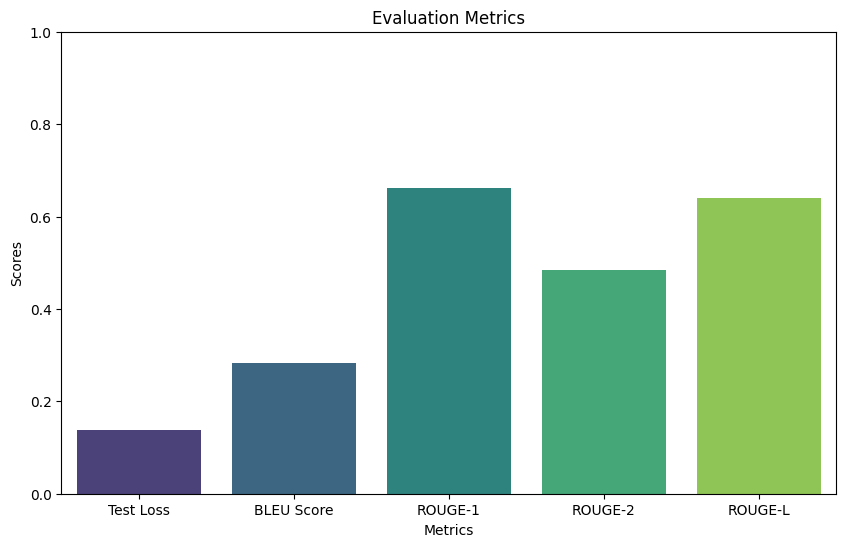

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch

# Ensure the model is on the GPU
model.to(device)

# Switch model to evaluation mode
model.eval()

# Define a function to evaluate the model on the test set
def evaluate_on_test(model, test_data, tokenizer, device):
    all_generated_texts = []
    all_target_texts = []
    total_loss = 0

    rouge_scorer_obj = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"])

    # Load test dataset into DataLoader
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=4)

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in tqdm(test_dataloader):
            # Move batch to the appropriate device (GPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass through the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # Decode predictions and references
            generated_ids = torch.argmax(logits, dim=-1)
            generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            target_text = tokenizer.decode(labels[0], skip_special_tokens=True)

            all_generated_texts.append(generated_text)
            all_target_texts.append(target_text)

    avg_loss = total_loss / len(test_dataloader)

    # BLEU Score Calculation
    bleu_score = corpus_bleu([[ref.split()] for ref in all_target_texts], [gen.split() for gen in all_generated_texts])

    # ROUGE Scores Calculation
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    for ref, gen in zip(all_target_texts, all_generated_texts):
        scores = rouge_scorer_obj.score(ref, gen)
        for key in rouge_scores:
            rouge_scores[key].append(scores[key].fmeasure)

    avg_rouge1 = np.mean(rouge_scores["rouge1"])
    avg_rouge2 = np.mean(rouge_scores["rouge2"])
    avg_rougeL = np.mean(rouge_scores["rougeL"])

    return avg_loss, bleu_score, avg_rouge1, avg_rouge2, avg_rougeL


# Assuming `device` is either 'cuda' or 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure model is on the correct device
model.to(device)

# Evaluate on the test set using your model and test data
test_loss, bleu_score_test, rouge1_test, rouge2_test, rougeL_test = evaluate_on_test(
    model, test_data, tokenizer, device)

# Print the evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"BLEU Score: {bleu_score_test:.4f}")
print(f"ROUGE-1 Score: {rouge1_test:.4f}")
print(f"ROUGE-2 Score: {rouge2_test:.4f}")
print(f"ROUGE-L Score: {rougeL_test:.4f}")

# Graph for Evaluation Metrics
# Plotting the results using Matplotlib
metrics = ['Test Loss', 'BLEU Score', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']
values = [test_loss, bleu_score_test, rouge1_test, rouge2_test, rougeL_test]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title("Evaluation Metrics")
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.ylim(0, 1)  # Ensure the scores are between 0 and 1 (assuming they are in this range)
plt.show()

# Optionally, if you want to visualize the individual ROUGE scores as a time-series, you could collect them over multiple epochs and plot that.


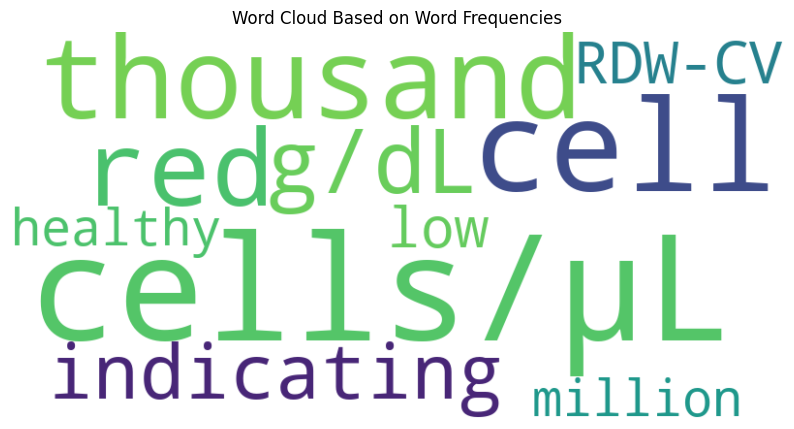

In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the word-frequency pairs
word_freq = [('cells/µL', 707), ('cell', 507), ('thousand', 430), ('red', 373), 
             ('g/dL', 295), ('indicating', 263), ('RDW-CV', 238), ('low', 219), 
             ('healthy', 177), ('million', 175)]

# Convert to a dictionary
word_freq_dict = dict(word_freq)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Based on Word Frequencies")
plt.show()
